<a href="https://colab.research.google.com/github/solllull/entregasML/blob/main/tp3_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales

## Trabajo Práctico 3: Como perros y gatos

In [120]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path
import os

# lib para trabajar con arrays
import numpy as np
import cv2
from PIL import Image

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
import plotly.express as px

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [121]:
TIPO = "dogs", "cats"
TRAINING_DIR = Path('./imagenes_tp3_cv/training_set')
TEST_DIR = Path('./imagenes_tp3_cv/test_set')

## Distribución de la variable a predecir

Buscamos predecir si, dada una imagen, pertecene a un perro o a un gato. El dataset de train contiene 4000 imágenes de perros y 4000 de gatos. El de test contiene 1000 de cada clase. Por ende, ambos datasets están perfectamente balanceados.

In [123]:
def sample_images(dataset):
    for images, labels in dataset.take(1):
        for i in range(9):
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(TIPO[np.argmax(labels[i])])
            plt.axis("off")

In [124]:
# devuelve tamaño imagen del path
def getImageDimension(path):
    im = Image.open(path)
    width, height = im.size
    return width, height

## Análisis de dimensiones de las imágenes

In [125]:
# cats
x = [] # width
y = [] # height
for i in range(1, 4000):
    path = str(Path(TRAINING_DIR)) + "\cats\cat."+ str(i) + ".jpg"
    width, height = getImageDimension(path)
    x.append(width)
    y.append(height)

fig = px.scatter(x=x, y=y)
fig.show()

In [126]:
# dogs
x = [] # width
y = [] # height
for i in range(1, 4000):
    path = str(Path(TRAINING_DIR)) + "\dogs\dog."+ str(i) + ".jpg"
    width, height = getImageDimension(path)
    x.append(width)
    y.append(height)

fig = px.scatter(x=x, y=y)
fig.show()

Observando los gráficos de dispersión anteriores, vemos que la distribución de las dimensiones que poseen las imágenes, es bastante dispersa. Por lo tanto, las llevamos a todas a una dimensión de 64 x 64.

In [127]:
train = image_dataset_from_directory(
    TRAINING_DIR,
    labels="inferred",  # adivinar los labels en base al nombre del sub directorio 
    label_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    class_names=TIPO,  # para usar el mismo orden en todos lados
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    image_size=(64, 64),  # para que corra más rápido, vamos a achicar las imágenes
    shuffle=True,  # que recorra el set de imágenes en orden aleatorio
    seed=42,  # semilla para que la aleatoriedad sea repetible
)

Found 8005 files belonging to 2 classes.


In [128]:
test = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=TIPO,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=42,
)

Found 2023 files belonging to 2 classes.


In [129]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(TIPO[np.argmax(labels[i])])
            plt.axis("off")

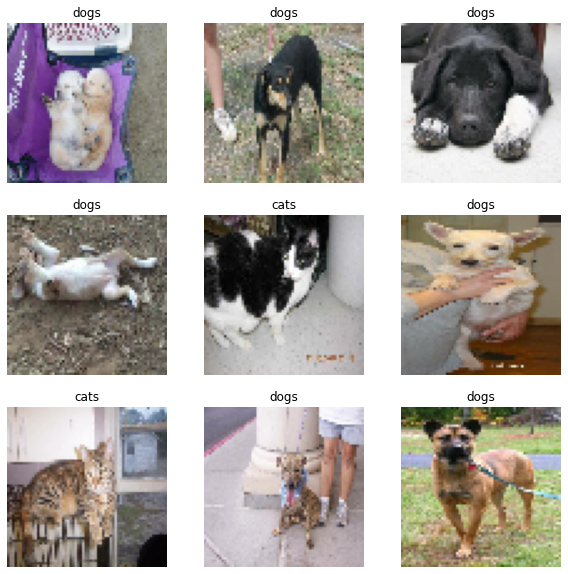

In [130]:
sample_images(train)

## MLP

In [131]:
mlp = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    # usamos una capa de Rescaling para normalizar las entradas de los datasets
    Rescaling(1/255, input_shape=(64, 64, 3)),
    Dense(30, activation='relu'),
    Dropout(0.2),
    Flatten(),
    
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='relu'),
    Dense(20, activation='relu'),
    Dropout(0.1),
    Dense(20, activation='relu'),
    Dense(10, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(len(TIPO), activation='sigmoid'),
])

mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [132]:
mlp.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
dense_28 (Dense)             (None, 64, 64, 30)        120       
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 30)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 122880)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                1228810   
_________________________________________________________________
dense_30 (Dense)             (None, 10)                110       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)               

In [133]:
mlp_history = mlp.fit(
    train,
    epochs=10,
    batch_size=128,
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 44s 170ms/step - loss: 0.6931 - accuracy: 0.5060 - val_loss: 0.6846 - val_accuracy: 0.5220
Epoch 2/10
251/251 [==============================] - 43s 172ms/step - loss: 0.6854 - accuracy: 0.5527 - val_loss: 0.6671 - val_accuracy: 0.6120
Epoch 3/10
251/251 [==============================] - 42s 166ms/step - loss: 0.6612 - accuracy: 0.6078 - val_loss: 0.6374 - val_accuracy: 0.6668
Epoch 4/10
251/251 [==============================] - 40s 158ms/step - loss: 0.6407 - accuracy: 0.6358 - val_loss: 0.6316 - val_accuracy: 0.6683
Epoch 5/10
251/251 [==============================] - 40s 157ms/step - loss: 0.6242 - accuracy: 0.6601 - val_loss: 0.6289 - val_accuracy: 0.6555
Epoch 6/10
251/251 [==============================] - 44s 172ms/step - loss: 0.6195 - accuracy: 0.6709 - val_loss: 0.6188 - val_accuracy: 0.6752
Epoch 7/10
251/251 [==============================] - 48s 190ms/step - loss: 0.6109 - accuracy: 0.6739 - val_loss: 0.6094 - val_ac

######################### train #########################
accuracy 0.736789506558401


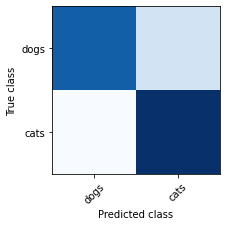

######################### test #########################
accuracy 0.6880869995056846


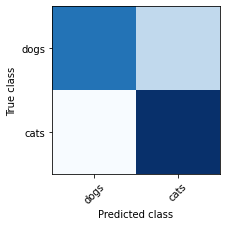

In [134]:
datasets = (
    ("train", train),
    ("test", test),   
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    # el dataset se itera en batches, así que calculamos predicciones y labels por cada batch, y luego 
    # concatenamos todo
    batches_predictions = []
    batches_labels =  []
    
    for batch_images, batch_labels in dataset:
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        batches_predictions.append(np.argmax(mlp.predict(batch_images), axis=-1))
        batches_labels.append(np.argmax(batch_labels, axis=-1))

    predictions = np.concatenate(batches_predictions)
    labels = np.concatenate(batches_labels)
    
    print('accuracy', accuracy_score(labels, predictions))

    # graficamos las confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], TIPO, rotation=45)
    plt.yticks([0, 1], TIPO)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

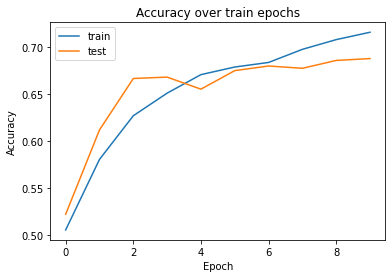

In [135]:
plt.plot(mlp_history.history['accuracy'], label='train')
plt.plot(mlp_history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Conclusiones MLP

Con este modelo logramos aproximadamente un 69% de accuracy con 10 épocas (usando el dataset de test). Si observamos la gráfica que muestra cómo evoluciona accuracy a través de las distintas épocas, vemos que tanto para el dataset de train como el de test, va aumentando el valor de la métrica indicada.

Si vemos las matrices de confusión, observamos que en el dataset de imágenes de train hay un gran acierto en ambas clases (accuracy del 73%), siendo más notable en la clase "cats". En la clase "dogs" se nota una leve cantidad de falsos positivos (predice "cats" cuando en realidad es "dogs").

En el dataset de test se consiguió un accuracy del 69%. Como se puede observar en la matriz de confusión se equivoca más al predecir si una imagen corresponde a un perro (clase "dogs"). Los falsos positivos de perros siguen siendo mayores que los de gatos.

In [136]:
from IPython.display import Image, display

def show_and_predict_mlp(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = mlp.predict(inputs)
    display(Image(image_path, width=200))
    print("Prediction:", TIPO[np.argmax(predictions)])
    print("Prediction detail:", predictions)

### Ejemplos de aciertos

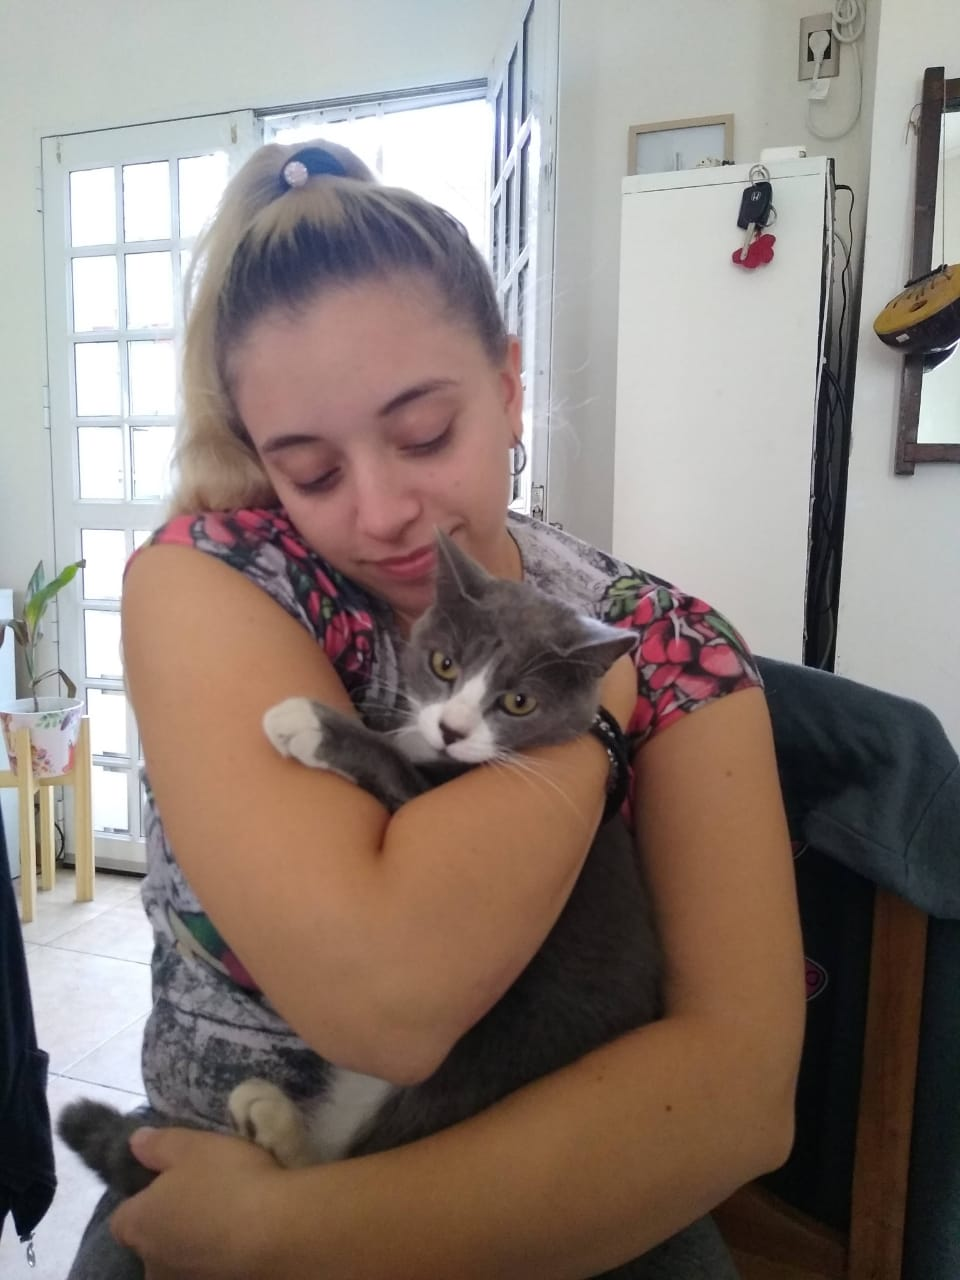

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


In [137]:
show_and_predict_mlp("./ejemplos/diana.jpeg")

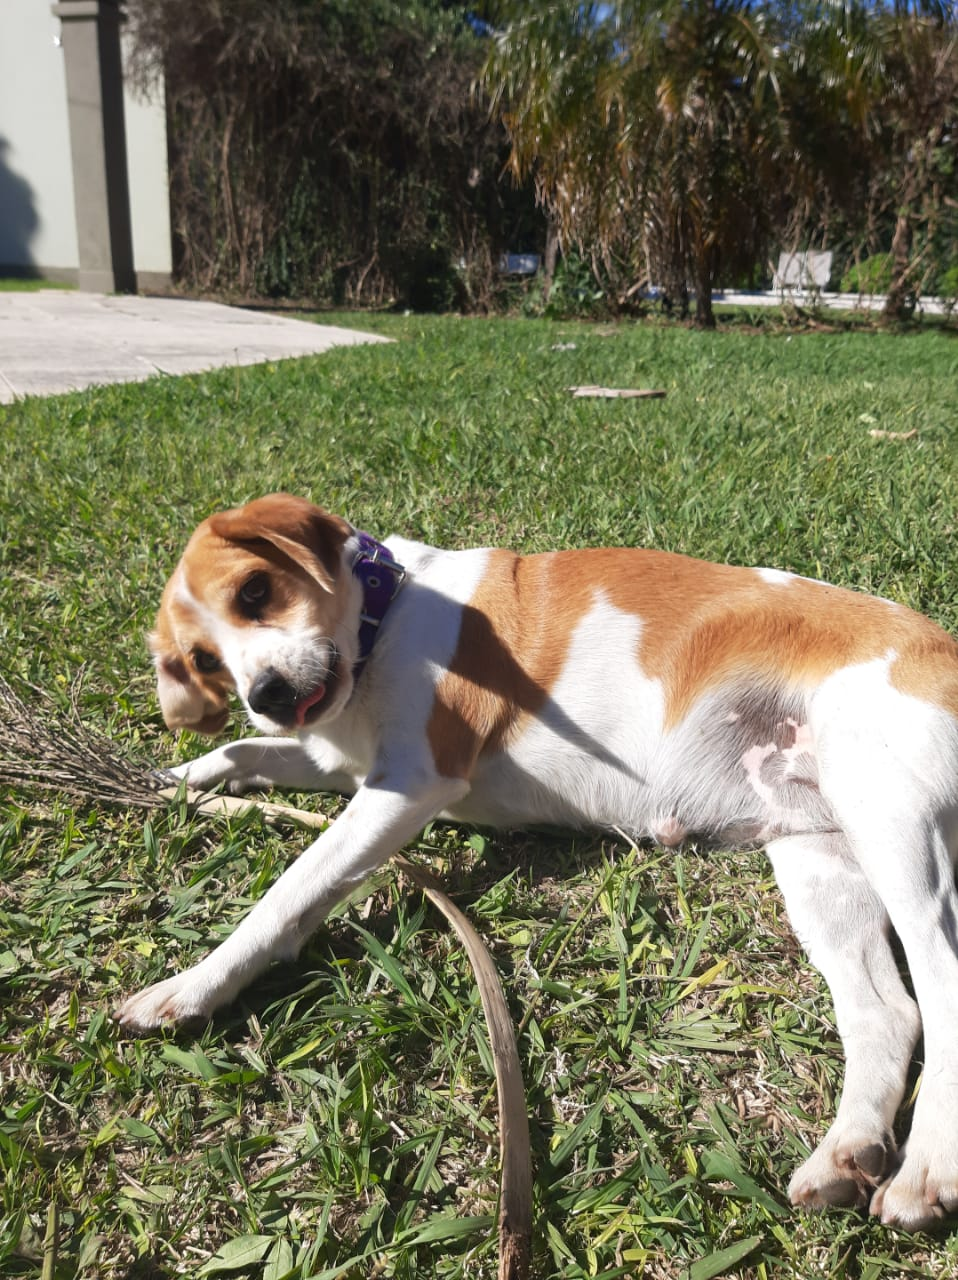

Prediction: dogs
Prediction detail: [[0.70249516 0.29890364]]


In [138]:
show_and_predict_mlp("./ejemplos/juana.jpeg")

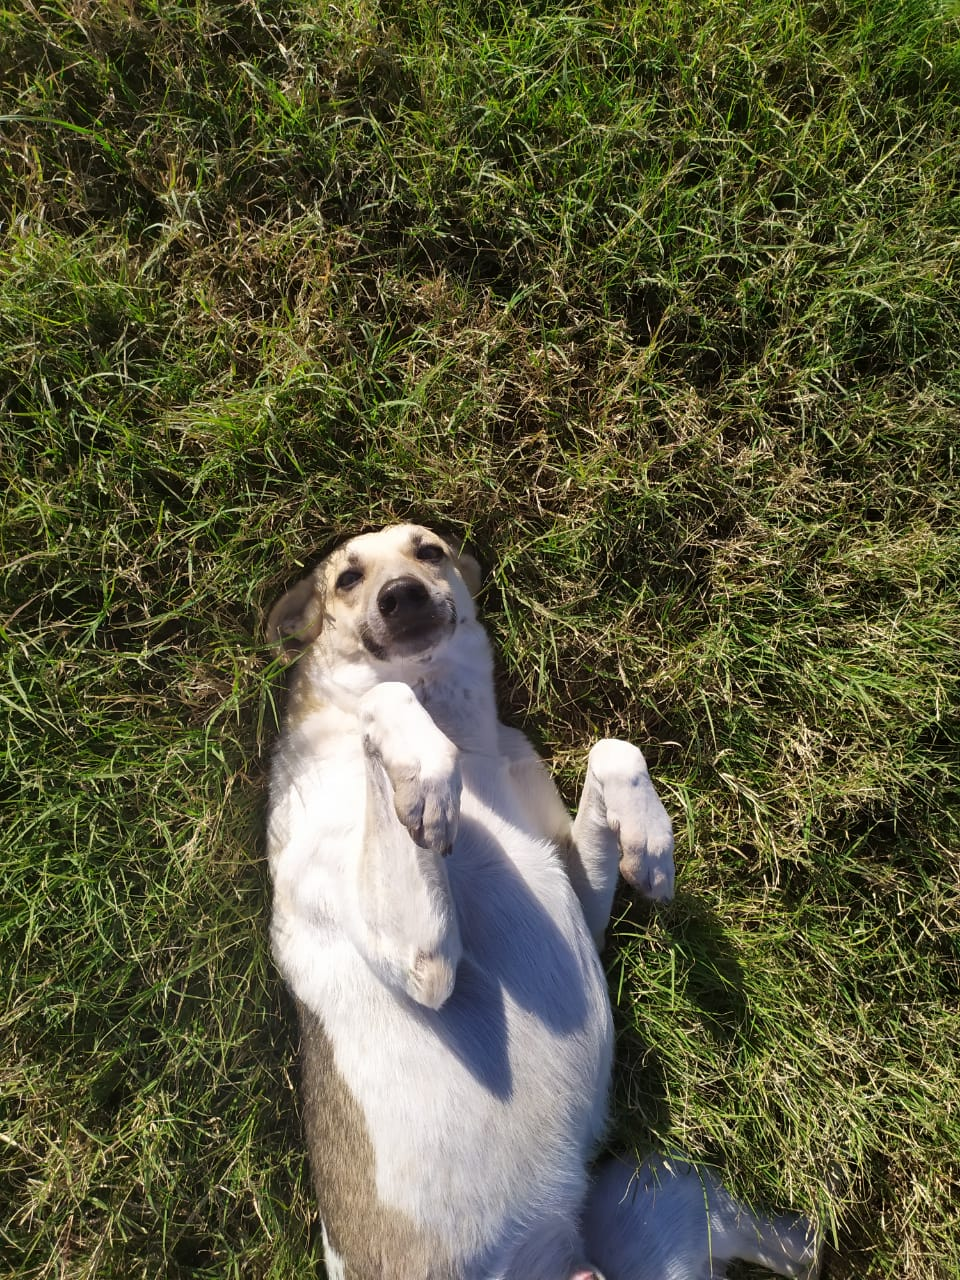

Prediction: dogs
Prediction detail: [[0.6381502 0.3709919]]


In [140]:
show_and_predict_mlp("./ejemplos/quito.jpeg")

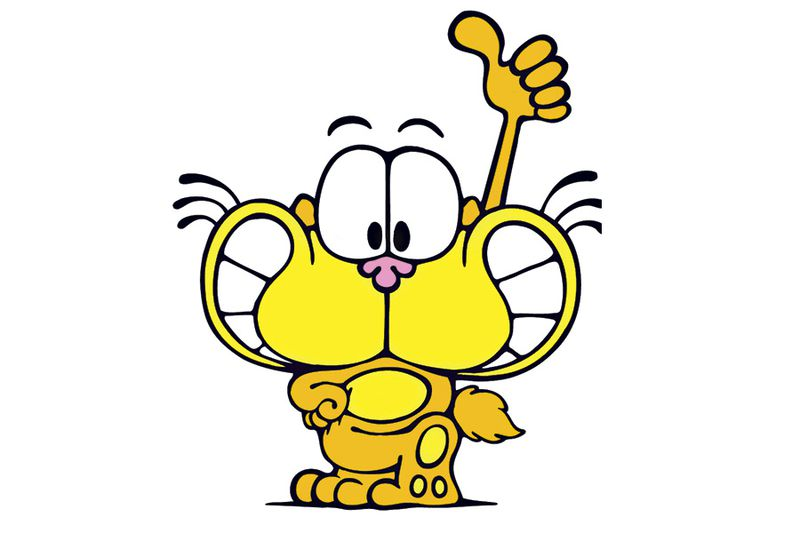

Prediction: cats
Prediction detail: [[0.50174093 0.5105933 ]]


In [141]:
show_and_predict_mlp("./ejemplos/gaturro.jpg")

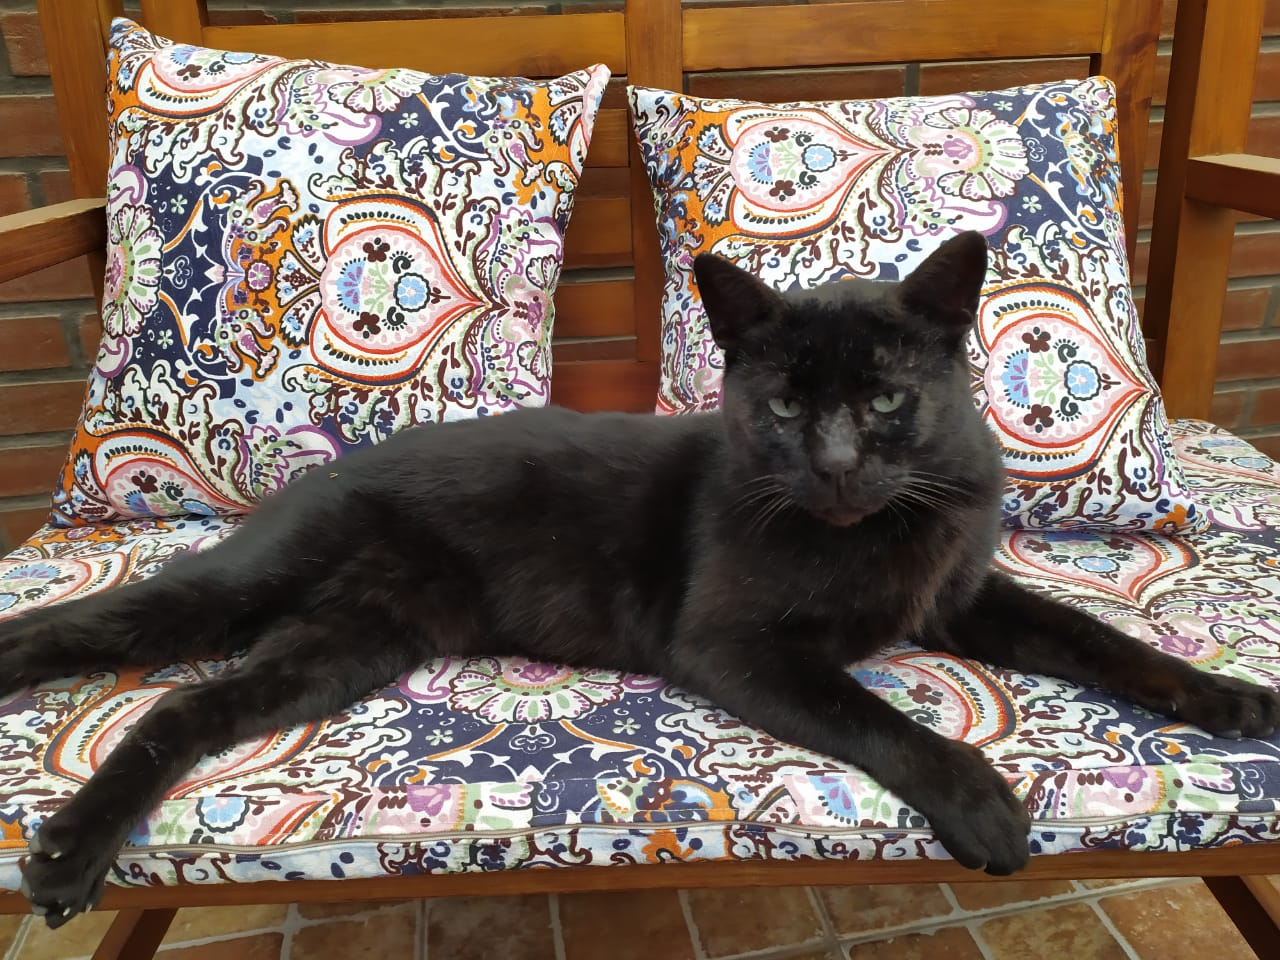

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


In [142]:
show_and_predict_mlp("./ejemplos/morcilla.jpeg")

### Ejemplos de no aciertos

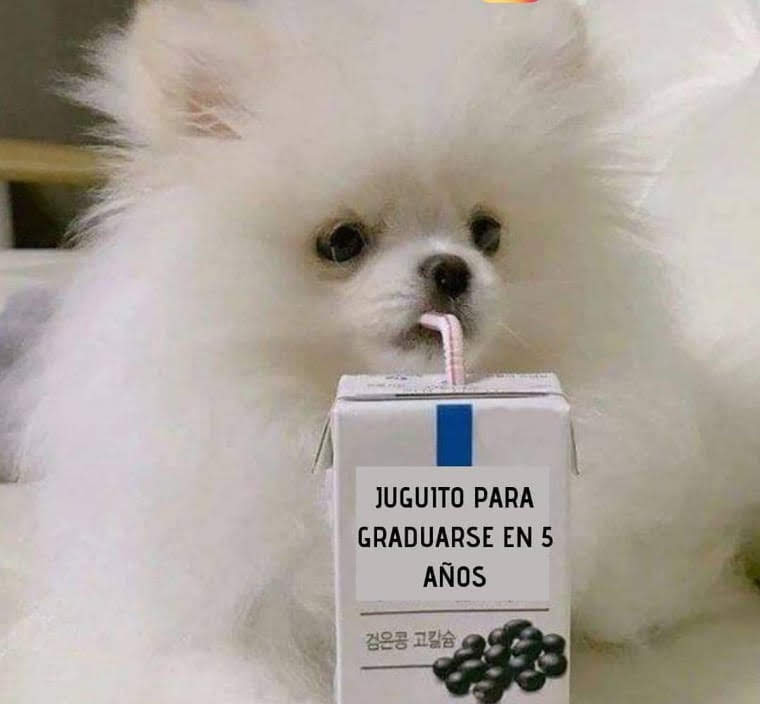

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


In [139]:
show_and_predict_mlp("./ejemplos/meme.jpeg")

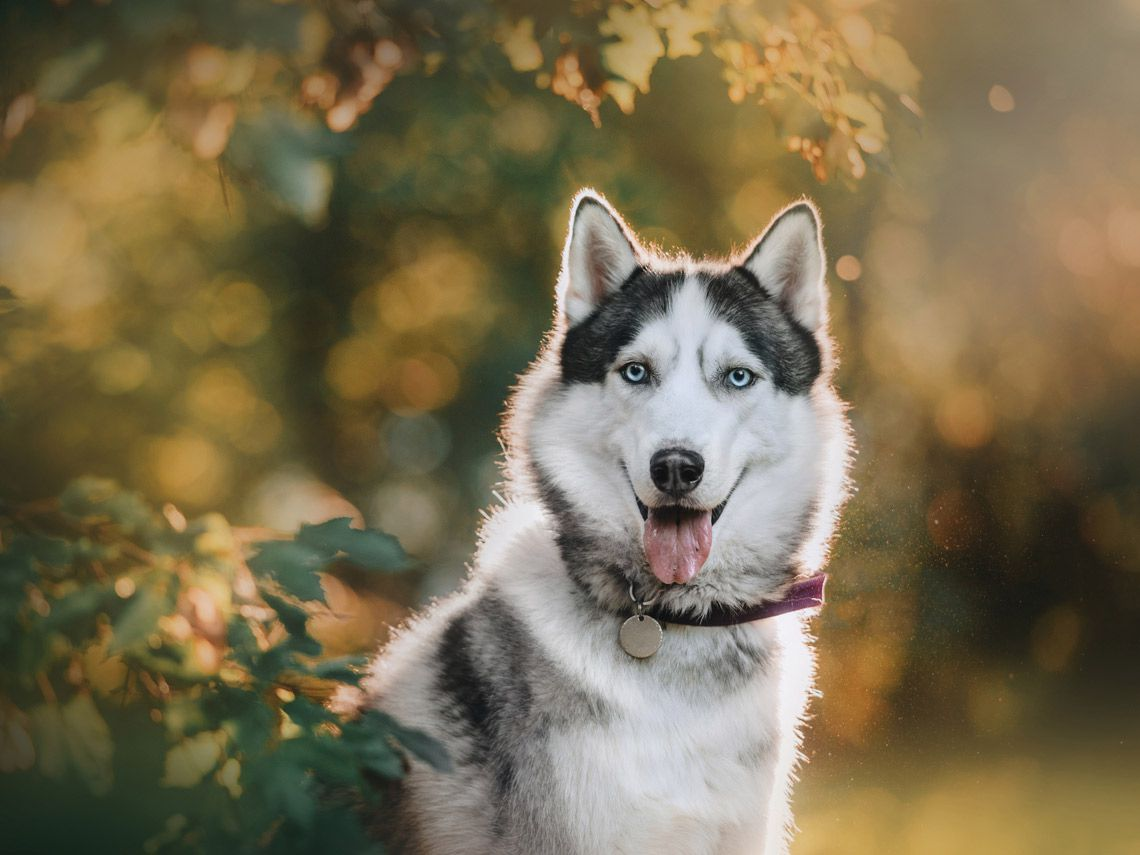

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


In [143]:
show_and_predict_mlp("./ejemplos/siberiano.jpg")

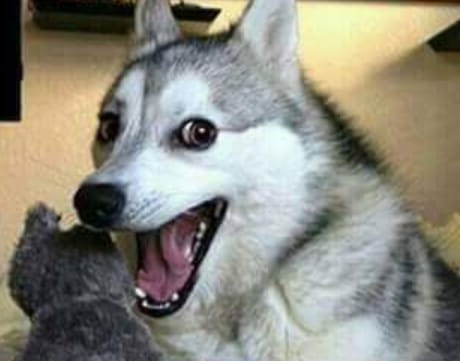

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


In [144]:
show_and_predict_mlp("./ejemplos/perro_meme.jpeg")

A continuación, mostramos casos en los que predice "cats" pero en realidad se muestran perros en las imágenes. Para ello utilizamos ejemplos del dataset de train.

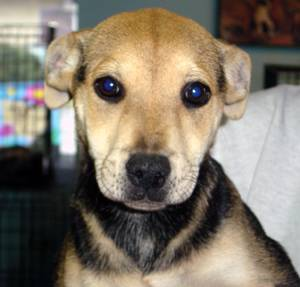

Prediction: cats
Prediction detail: [[0.36114615 0.6486806 ]]


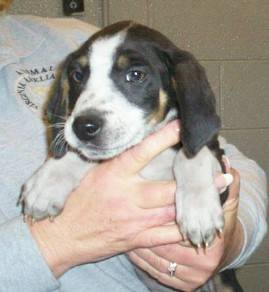

Prediction: cats
Prediction detail: [[0.49324444 0.51802707]]


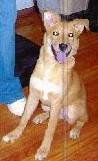

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


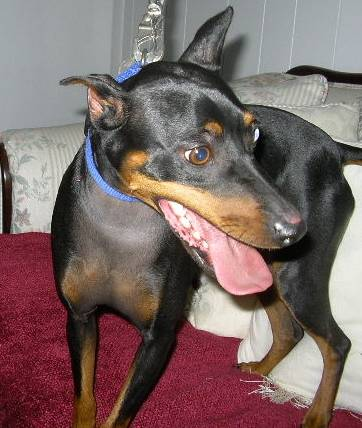

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


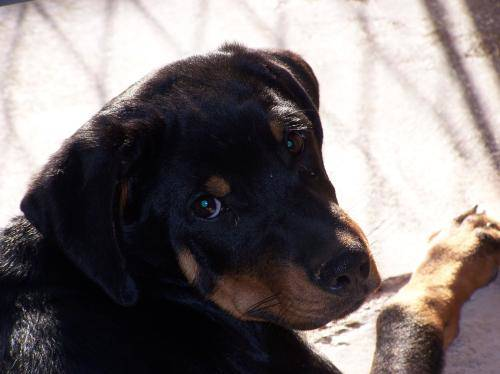

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


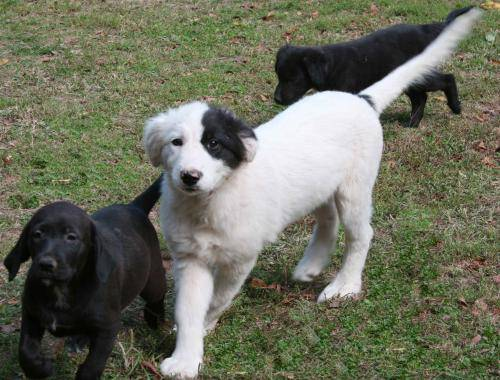

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


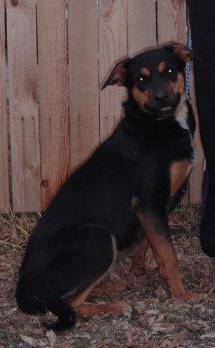

Prediction: cats
Prediction detail: [[0.44627607 0.56114477]]


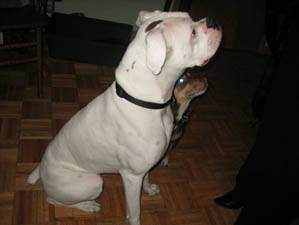

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


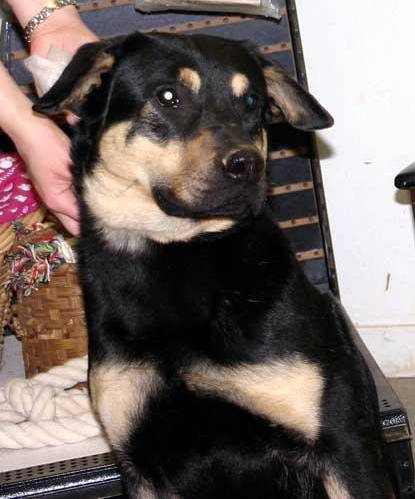

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


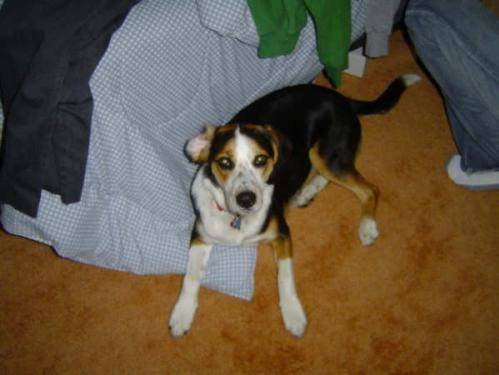

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


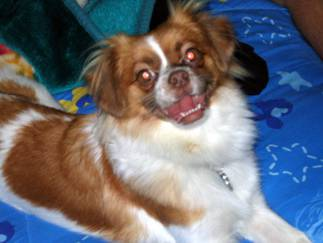

Prediction: cats
Prediction detail: [[0.2797449  0.71400726]]


In [145]:
for i in range(1, 40):
    path = str(Path(TRAINING_DIR)) + "\dogs\dog."+ str(i) + ".jpg"
    image_array = img_to_array(load_img(path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = mlp.predict(inputs)
    if TIPO[np.argmax(predictions)] != "dogs":
        display(Image(path, width=200))
        print("Prediction:", TIPO[np.argmax(predictions)])
        print("Prediction detail:", predictions)
    

## Convolución

In [146]:
cnn = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    # usamos una capa de Rescaling para normalizar las entradas de los datasets
    Rescaling(1/255, input_shape=(64, 64, 3)),
    
    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    
    Dense(len(TIPO), activation='softmax'),
    
])

cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [147]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 128)        

In [148]:
cnn_history = cnn.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 45s 176ms/step - loss: 0.6921 - accuracy: 0.5380 - val_loss: 0.6400 - val_accuracy: 0.6283
Epoch 2/5
251/251 [==============================] - 45s 176ms/step - loss: 0.6105 - accuracy: 0.6628 - val_loss: 0.5640 - val_accuracy: 0.7148
Epoch 3/5
251/251 [==============================] - 45s 179ms/step - loss: 0.5407 - accuracy: 0.7275 - val_loss: 0.5167 - val_accuracy: 0.7612
Epoch 4/5
251/251 [==============================] - 45s 179ms/step - loss: 0.4902 - accuracy: 0.7628 - val_loss: 0.4767 - val_accuracy: 0.7776
Epoch 5/5
251/251 [==============================] - 45s 176ms/step - loss: 0.4507 - accuracy: 0.7879 - val_loss: 0.6115 - val_accuracy: 0.7034


######################### train #########################
accuracy 0.7466583385384135


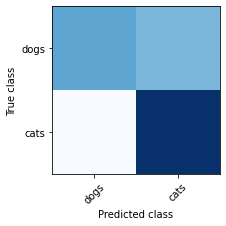

######################### test #########################
accuracy 0.7034107760751359


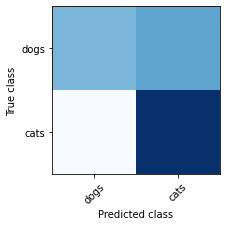

In [149]:
datasets = (
    ("train", train),
    ("test", test),   
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    # el dataset se itera en batches, así que calculamos predicciones y labels por cada batch, y luego 
    # concatenamos todo
    batches_predictions = []
    batches_labels =  []
    
    for batch_images, batch_labels in dataset:
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        batches_predictions.append(np.argmax(cnn.predict(batch_images), axis=-1))
        batches_labels.append(np.argmax(batch_labels, axis=-1))

    predictions = np.concatenate(batches_predictions)
    labels = np.concatenate(batches_labels)
    
    print('accuracy', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], TIPO, rotation=45)
    plt.yticks([0, 1], TIPO)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

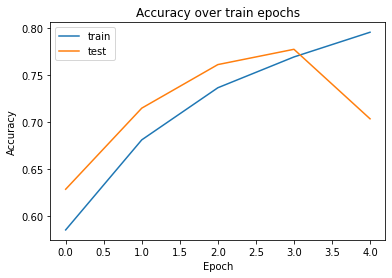

In [150]:
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Conclusiones CNN

Con este modelo logramos aproximadamente un 79% de accuracy con 5 épocas (usando el dataset de test). Si observamos la gráfica que muestra cómo evoluciona accuracy a través de las distintas épocas, vemos que tanto para el dataset de train como el de test, va aumentando el valor de la métrica indicada. 

Si vemos las matrices de confusión, observamos que en el dataset de imágenes de train se obtuvo un mayor acierto para ambas clases (accuracy del 86%), en comparación con el modelo MLP, siendo más notable en la clase "cats". En la clase "dogs" se nota una leve cantidad de falsos positivos (predice "cats" cuando en realidad es "dogs"). 

En el dataset de test se consiguió un accuracy del 79%. Como se puede observar en la matriz de confusión se equivoca más al predecir si una imagen corresponde a un perro (clase "dogs"). Los falsos positivos de perros siguen siendo mayores que los de gatos.

In [151]:
def show_and_predict_cnn(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array]) 
    predictions = cnn.predict(inputs)
    display(Image(image_path, width=200))
    print("Prediction:", TIPO[np.argmax(predictions)])
    print("Prediction detail:", predictions)

### Ejemplos de aciertos

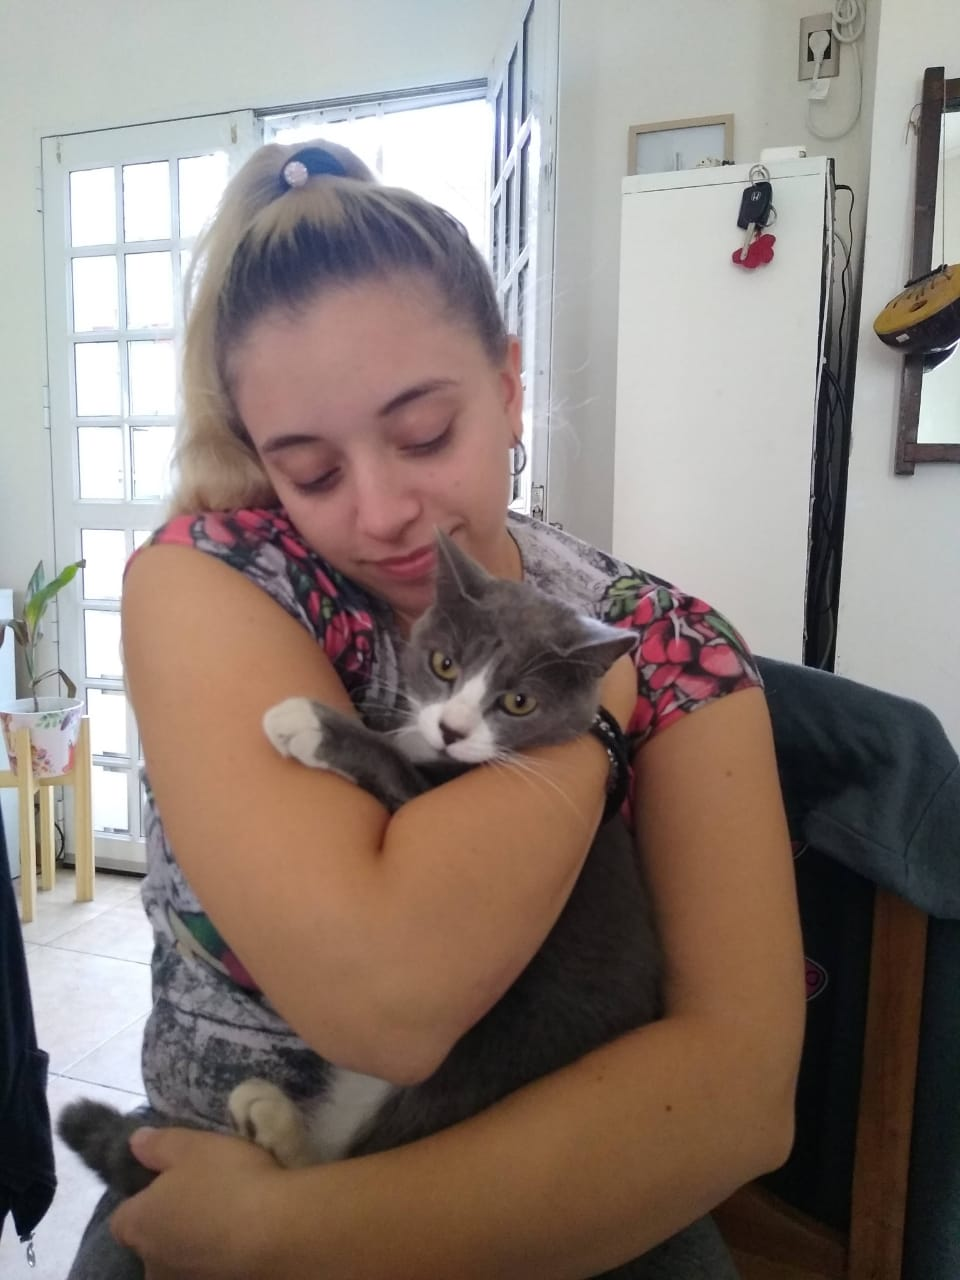

Prediction: cats
Prediction detail: [[0.06582643 0.9341736 ]]


In [154]:
show_and_predict_cnn("./ejemplos/diana.jpeg")

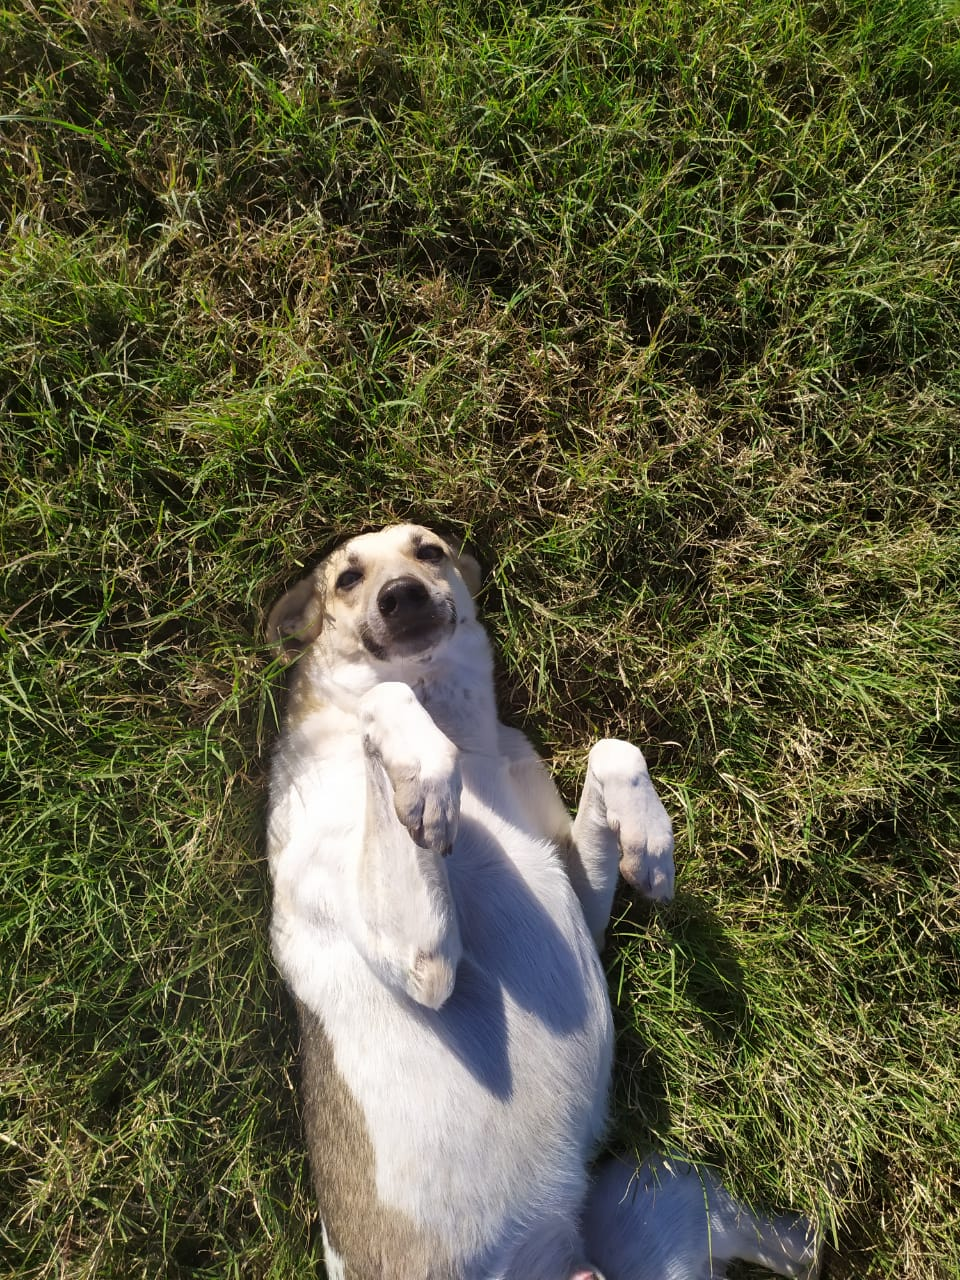

Prediction: dogs
Prediction detail: [[0.87268084 0.12731916]]


In [155]:
show_and_predict_cnn("./ejemplos/quito.jpeg")

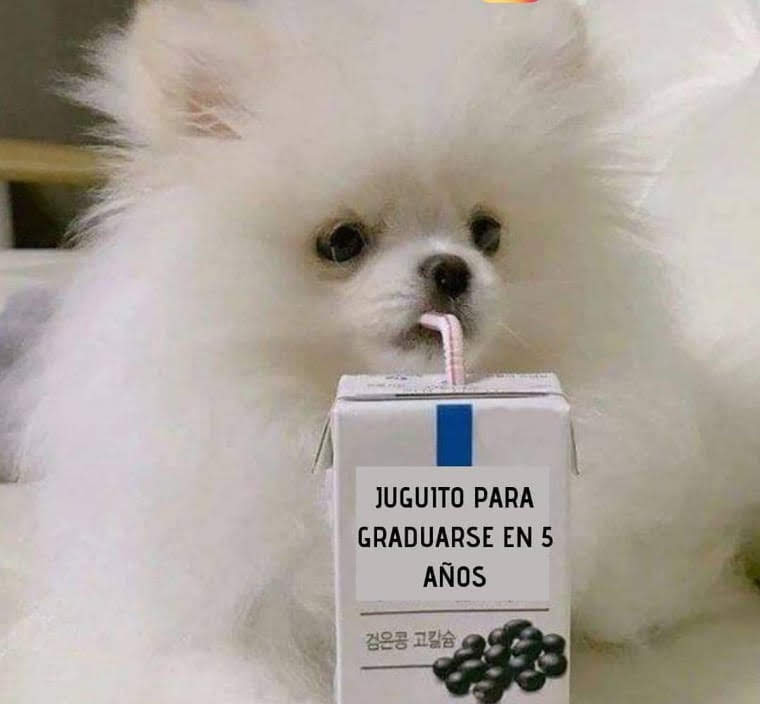

Prediction: dogs
Prediction detail: [[0.78223586 0.21776417]]


In [156]:
show_and_predict_cnn("./ejemplos/meme.jpeg")

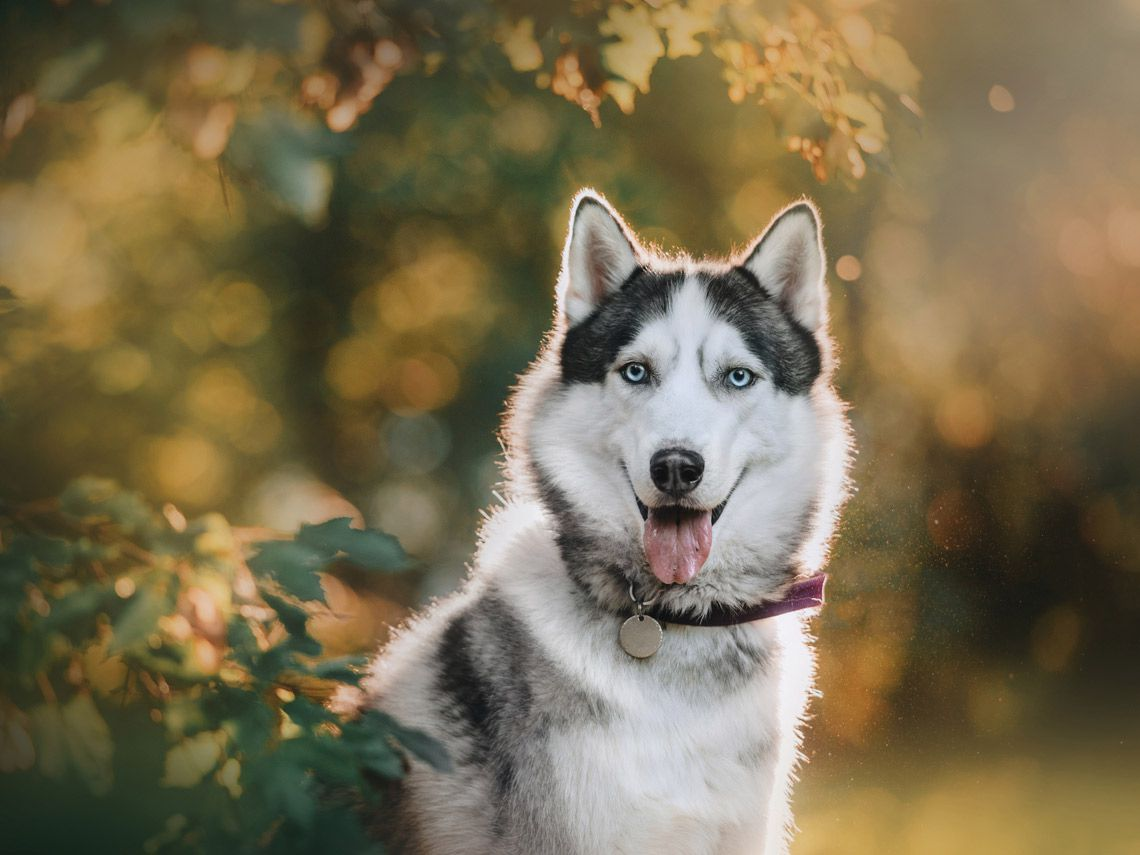

Prediction: dogs
Prediction detail: [[0.7287691  0.27123082]]


In [157]:
show_and_predict_cnn("./ejemplos/siberiano.jpg")

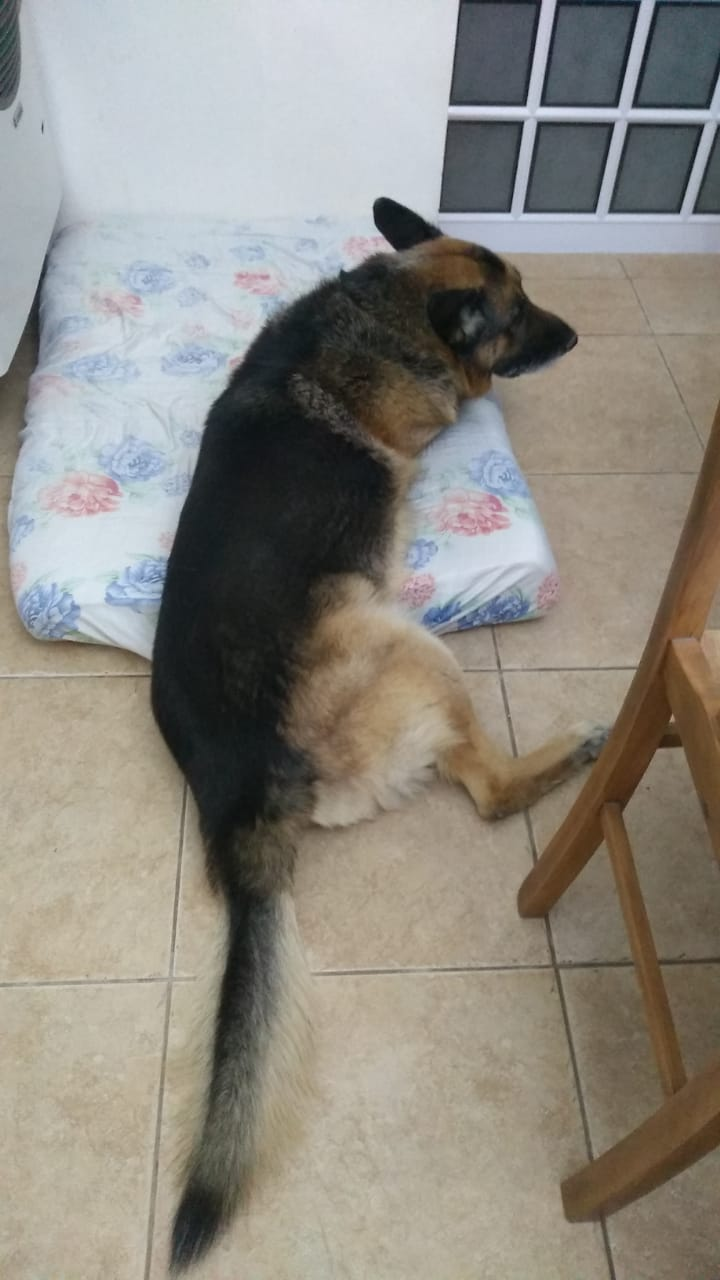

Prediction: dogs
Prediction detail: [[0.5528482  0.44715184]]


In [158]:
show_and_predict_cnn("./ejemplos/wilson.jpeg")

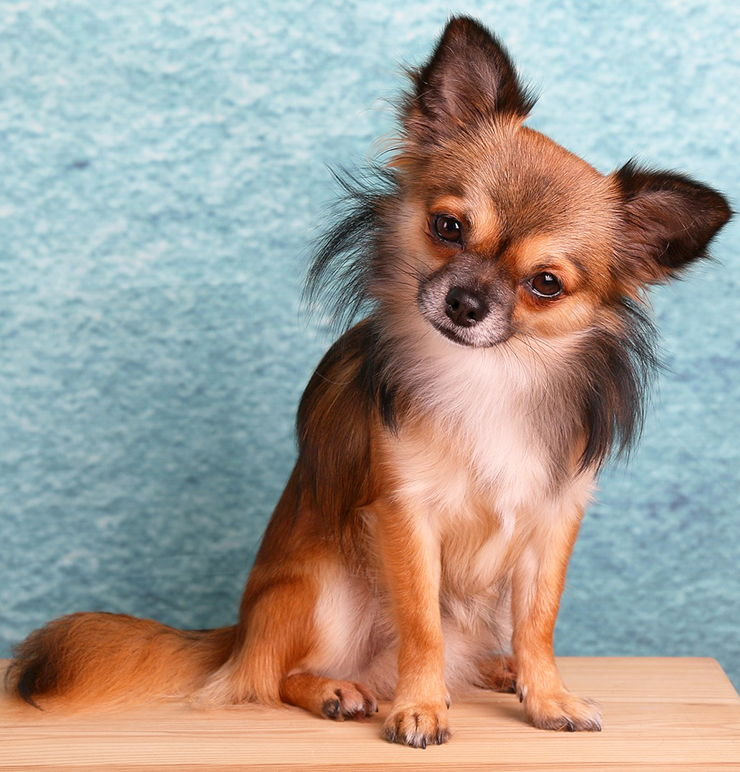

Prediction: dogs
Prediction detail: [[0.8057331  0.19426696]]


In [160]:
show_and_predict_cnn("./ejemplos/chihuahua.jpeg")

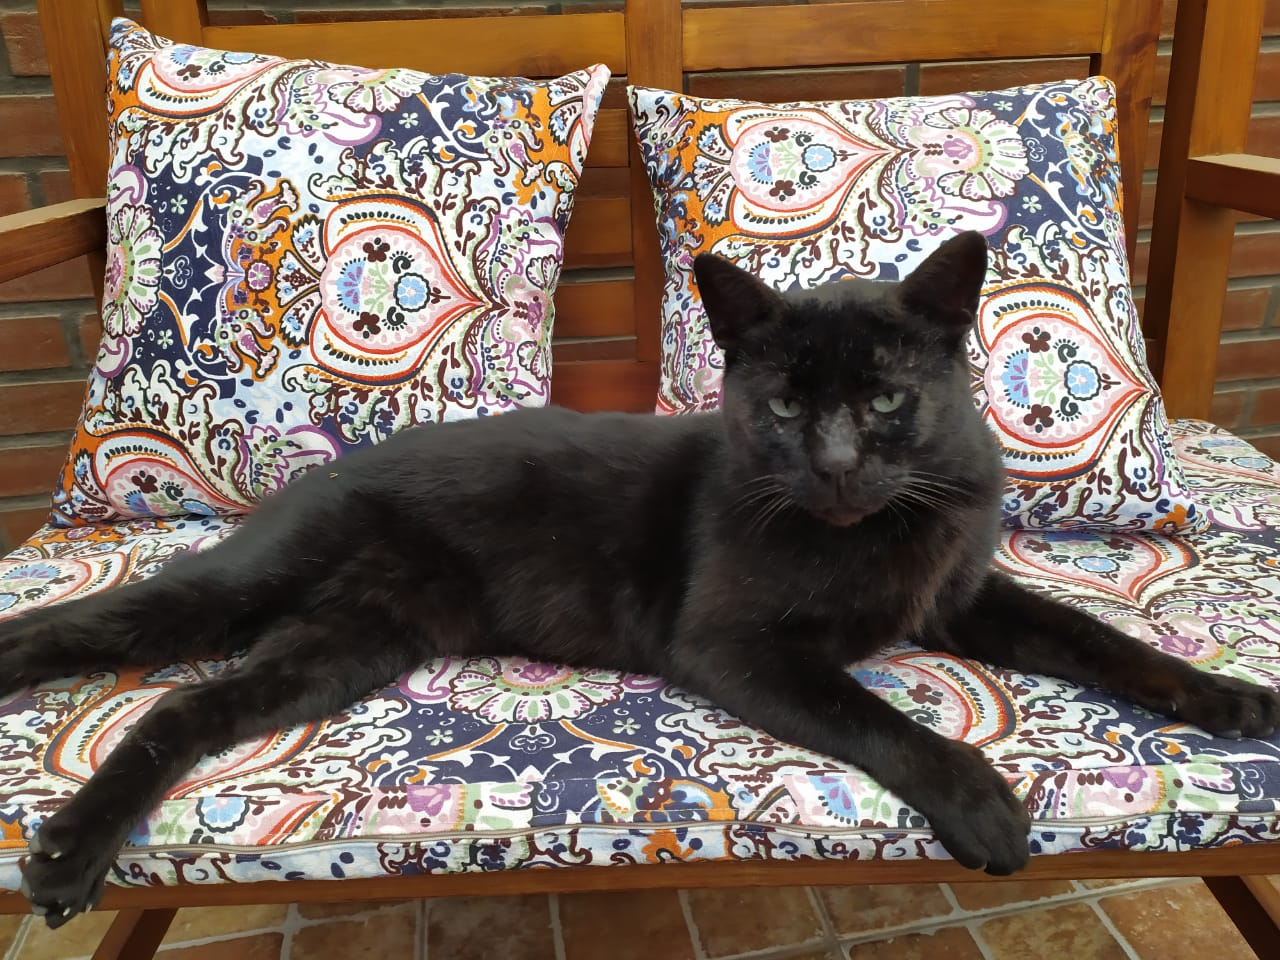

Prediction: cats
Prediction detail: [[0.14867413 0.8513258 ]]


In [161]:
show_and_predict_cnn("./ejemplos/morcilla.jpeg")

### Ejemplos de no aciertos

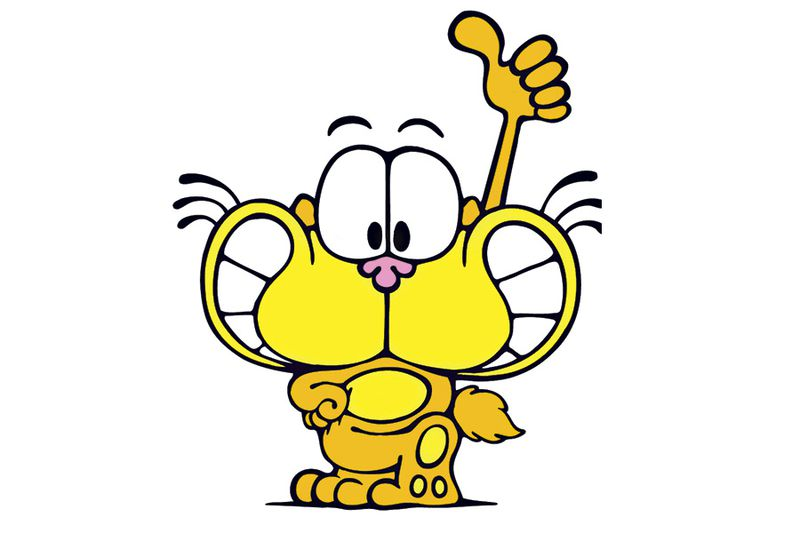

Prediction: dogs
Prediction detail: [[0.7300329  0.26996708]]


In [153]:
show_and_predict_cnn("./ejemplos/gaturro.jpg")

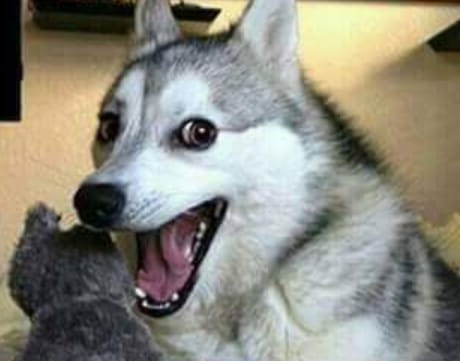

Prediction: cats
Prediction detail: [[0.470098   0.52990204]]


In [159]:
show_and_predict_cnn("./ejemplos/perro_meme.jpeg")

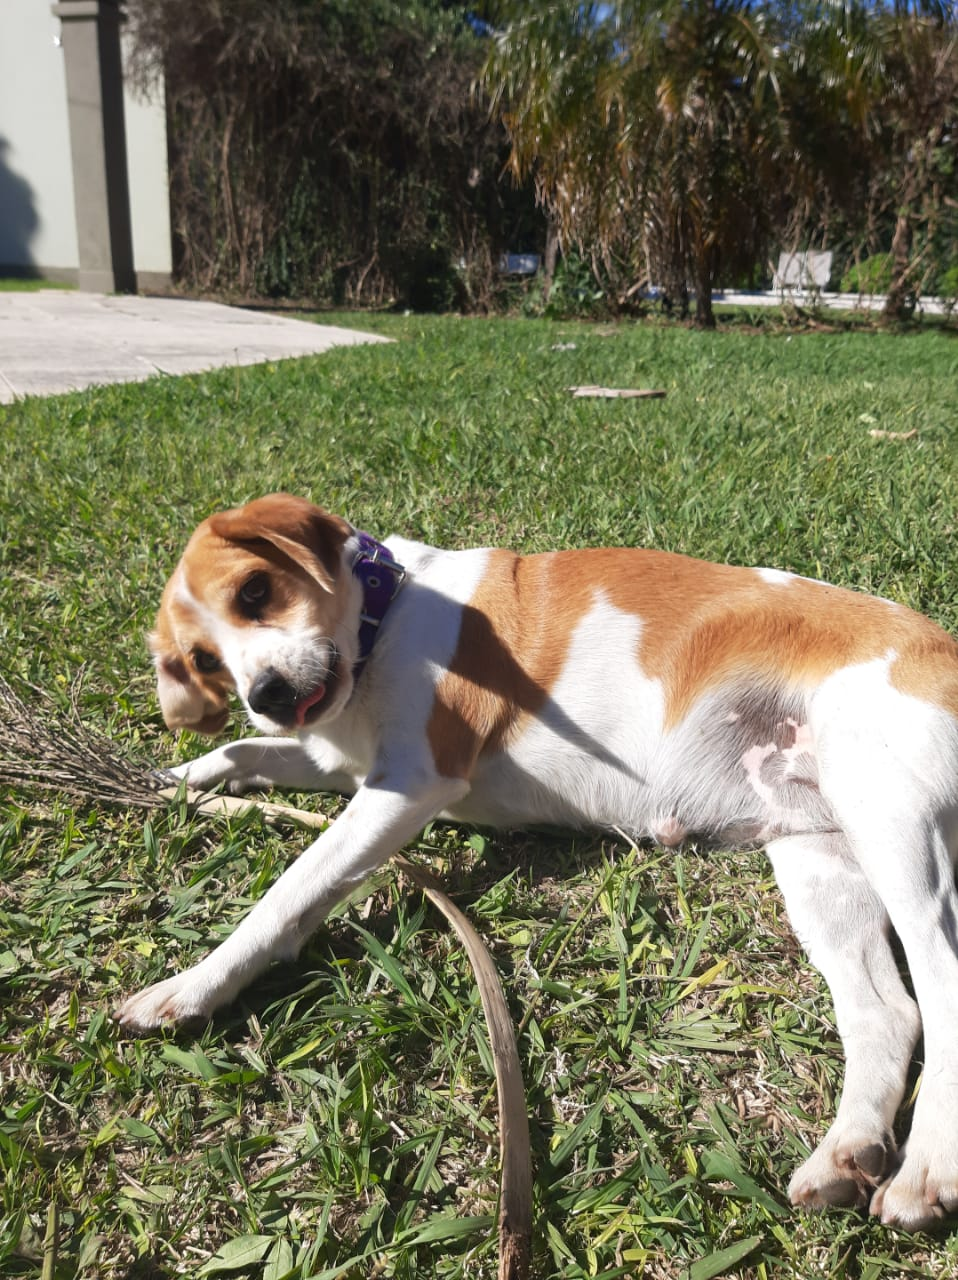

Prediction: cats
Prediction detail: [[0.42184582 0.5781541 ]]


In [152]:
show_and_predict_cnn("./ejemplos/juana.jpeg")

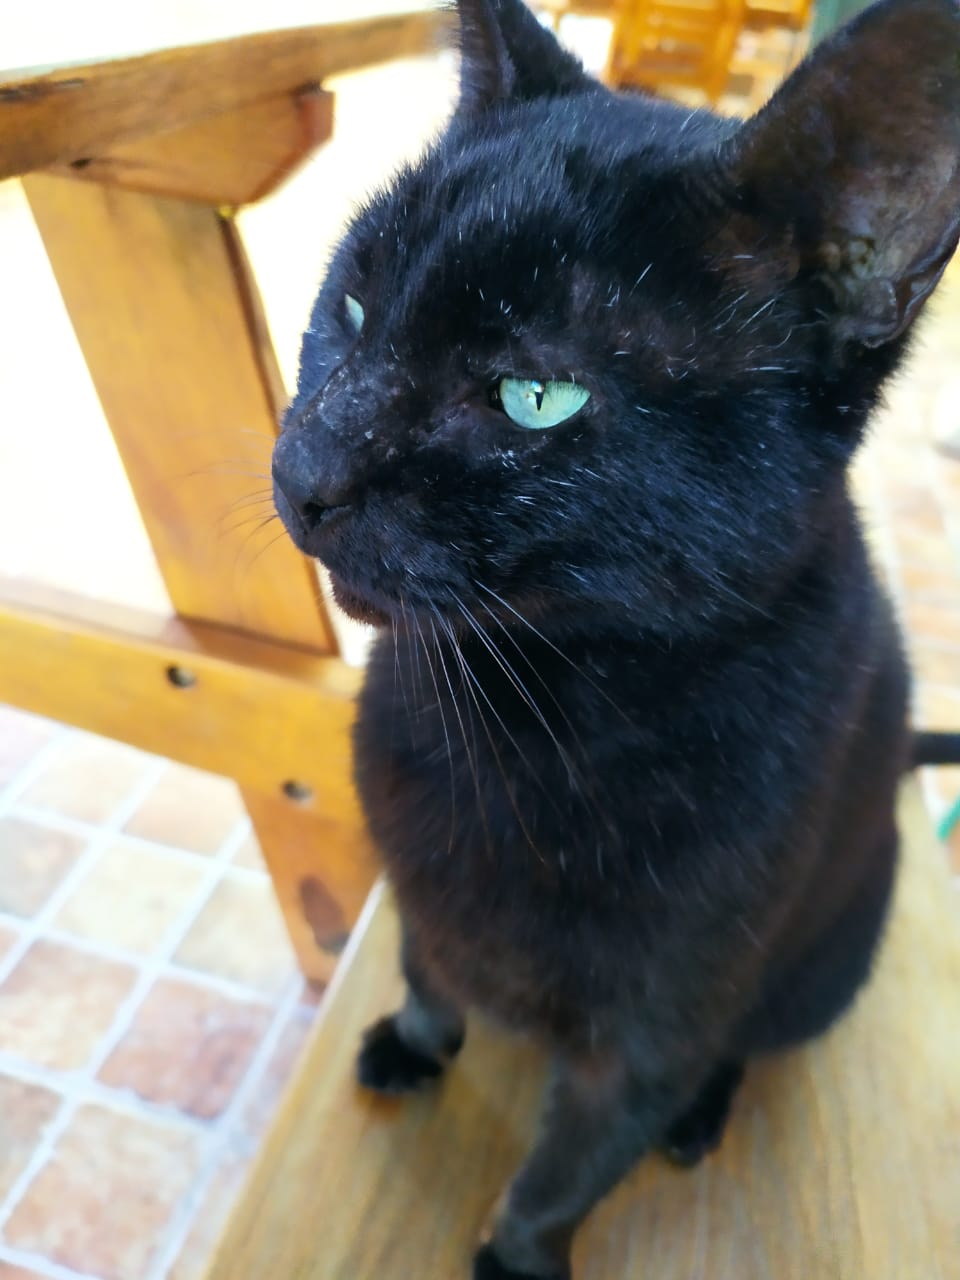

Prediction: dogs
Prediction detail: [[0.80691016 0.19308987]]


In [162]:
show_and_predict_cnn("./ejemplos/morci.jpeg")

A continuación, mostramos casos en los que predice "cats" pero en realidad se muestran perros en las imágenes. Para ello utilizamos ejemplos del dataset de train.

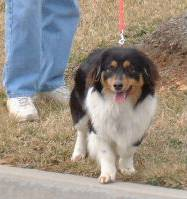

Prediction: cats
Prediction detail: [[0.49399656 0.5060034 ]]


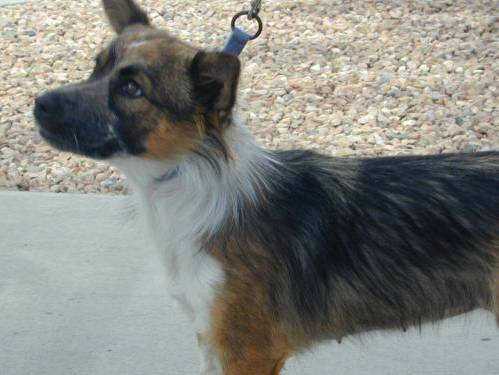

Prediction: cats
Prediction detail: [[0.14361411 0.8563859 ]]


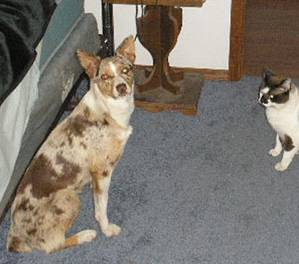

Prediction: cats
Prediction detail: [[0.11095706 0.8890429 ]]


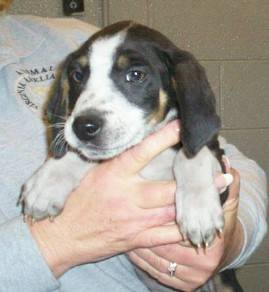

Prediction: cats
Prediction detail: [[0.48220274 0.5177973 ]]


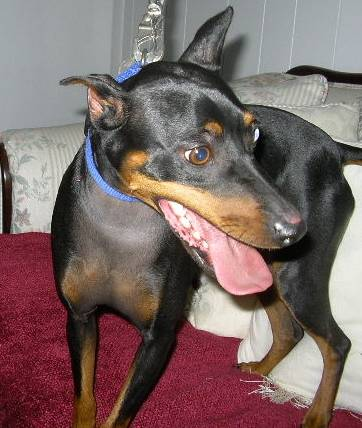

Prediction: cats
Prediction detail: [[0.2678469  0.73215306]]


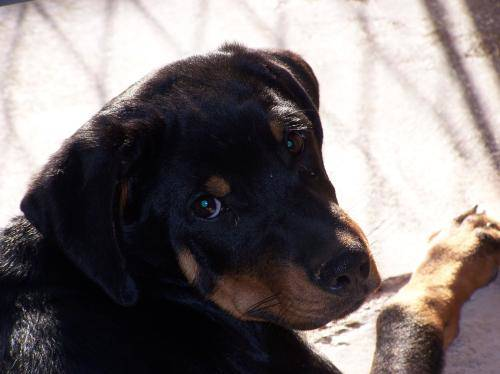

Prediction: cats
Prediction detail: [[0.11394345 0.8860566 ]]


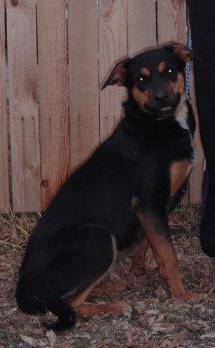

Prediction: cats
Prediction detail: [[0.15808117 0.8419188 ]]


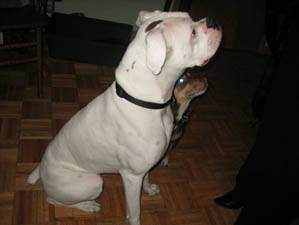

Prediction: cats
Prediction detail: [[0.07781444 0.92218554]]


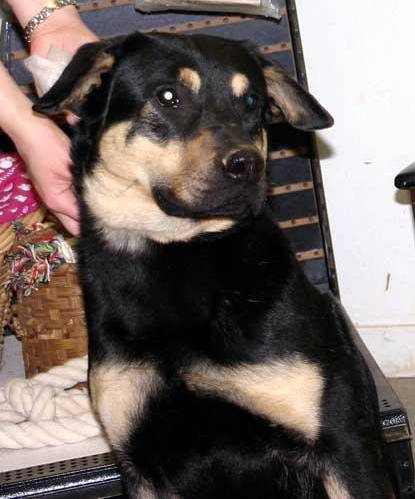

Prediction: cats
Prediction detail: [[0.25684315 0.74315685]]


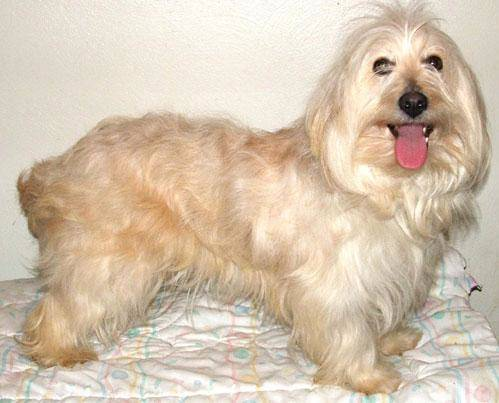

Prediction: cats
Prediction detail: [[0.4935445  0.50645554]]


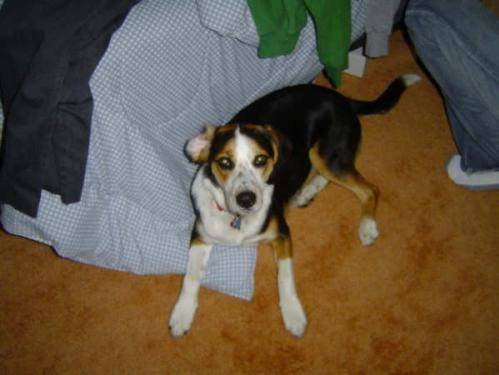

Prediction: cats
Prediction detail: [[0.26024953 0.7397505 ]]


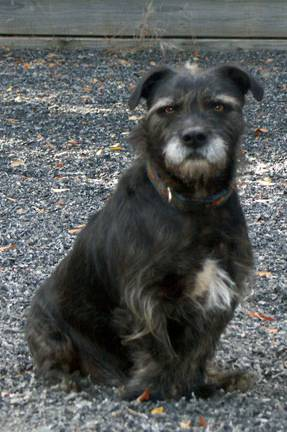

Prediction: cats
Prediction detail: [[0.34102464 0.6589754 ]]


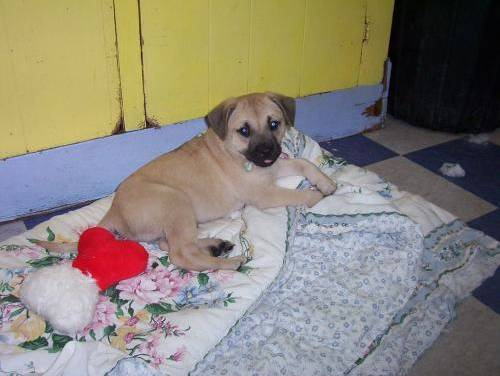

Prediction: cats
Prediction detail: [[0.22988284 0.77011716]]


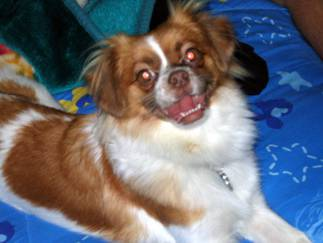

Prediction: cats
Prediction detail: [[0.3552393 0.6447607]]


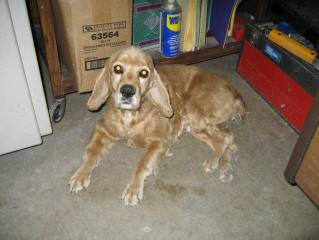

Prediction: cats
Prediction detail: [[0.3802491 0.619751 ]]


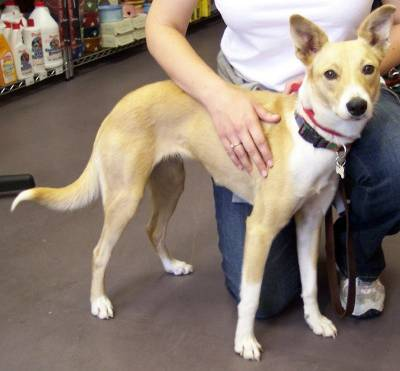

Prediction: cats
Prediction detail: [[0.41800627 0.5819937 ]]


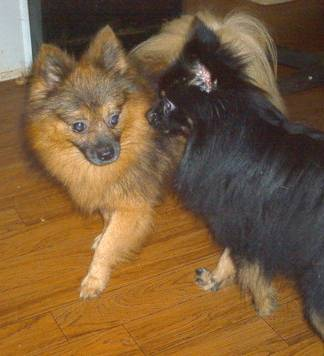

Prediction: cats
Prediction detail: [[0.48580256 0.51419747]]


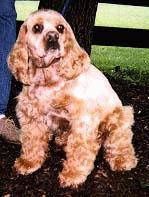

Prediction: cats
Prediction detail: [[0.21755551 0.78244454]]


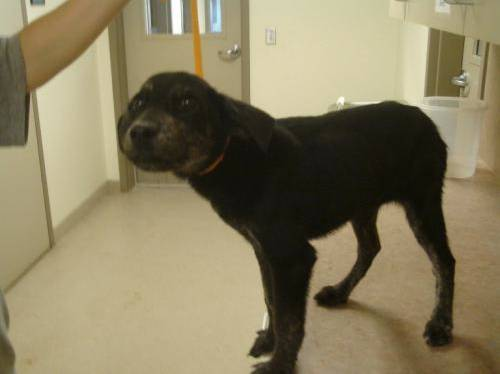

Prediction: cats
Prediction detail: [[0.12677829 0.87322176]]


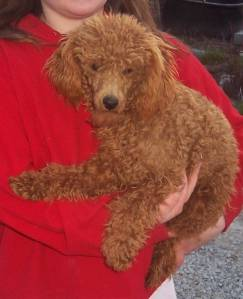

Prediction: cats
Prediction detail: [[0.259853   0.74014693]]


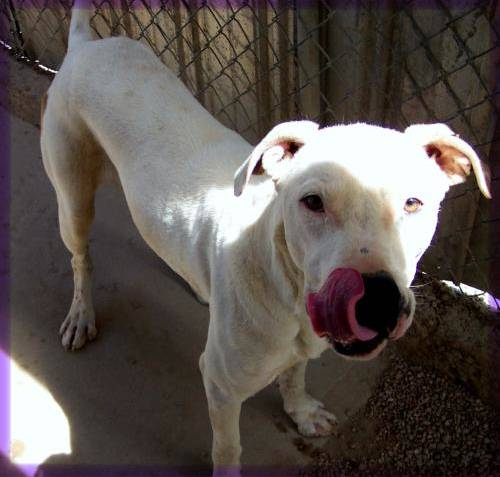

Prediction: cats
Prediction detail: [[0.20895053 0.7910495 ]]


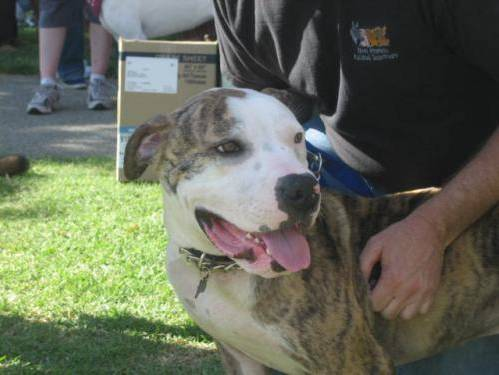

Prediction: cats
Prediction detail: [[0.38237658 0.6176234 ]]


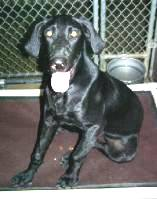

Prediction: cats
Prediction detail: [[0.16855021 0.83144987]]


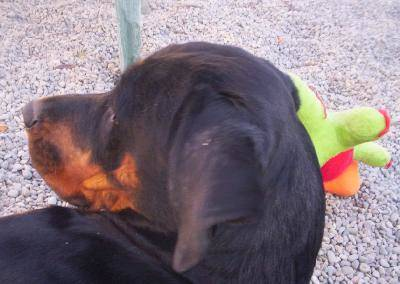

Prediction: cats
Prediction detail: [[0.42016885 0.5798311 ]]


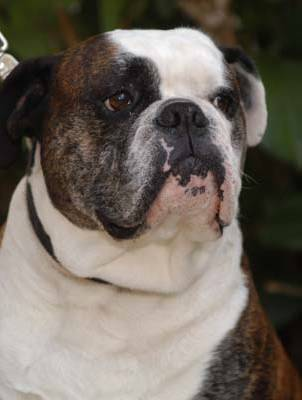

Prediction: cats
Prediction detail: [[0.31970128 0.6802987 ]]


In [163]:
for i in range(1, 60):
    path = str(Path(TRAINING_DIR)) + "\dogs\dog."+ str(i) + ".jpg"
    image_array = img_to_array(load_img(path, target_size=(64, 64)))
    inputs = np.array([image_array]) 
    predictions = cnn.predict(inputs)
    if TIPO[np.argmax(predictions)] != "dogs":
        display(Image(path, width=200))
        print("Prediction:", TIPO[np.argmax(predictions)])
        print("Prediction detail:", predictions)

### Posibles mejoras

Para mejorar el rendimiento de ambos modelos proponemos lo siguiente:
 * Disponer de un dataset con más imágenes.
 * Realizar Data Augmentation para introducir "perturbaciones" en los datos originales. Por ejemplo, tomar una imagen original centrada y replicarla descentrada, invirtiendo sus ejes, etc.
 * Seguir probando distintas alternativas de los modelos (MLP y CNN) cambiando capas, cantidad de neuronas, funciones de activación, etc.